### CAS Information Engineering - Project Module Scripting:
# Analyses on air quality and population growth in Zurich

*Severin Troesch, Nov 2019*

## Goals of analysis 
The goals of this analysis are the following:

- To determine the correlation between air quality indicators collected by two different measurement stations in the city of Zurich (s. step 4).
- To determine the correlation between population growth and temperature rise (aggregated per year) in the city of Zurich. (s. step 4)
- To perform a statistical dimensionality-reduction technique (t-SNE) on the aitquality data (s. step 5)
- To visually discriminate summer from winter months based on the dimeensionality-reduced airquality data (s. step 5)

## Step 1: Modules & settings

Necessary Python-modules are loaded and global plot settings are set:

In [554]:
# standard modules
import pandas as pd # V 0.25.1
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import io
import datetime as dt
import time
import pandas as pd
from scipy.stats import pearsonr #correlations
from sklearn.manifold import TSNE # for dimensionality reduction in step 5

# external modules
from cachetools import cached, TTLCache  # V 3.1.1; to import the "cached" decorator and the "TTLCache" object from cachetools

In [555]:
# set global figure parameters
sns.set(rc={'figure.figsize':(8,8), "font.size":15,"axes.titlesize":15,"axes.labelsize":15}, style = "white")

## Step 2: Data load & caching

Raw data is loaded from the chosen URLs and then cached for 60 s.

In [556]:
## store csv in cache and later convert to df

## prepare cache
os.getcwd() # data will be cached here

cachetime = 60 
mycache = TTLCache(maxsize = 2, ttl = cachetime)  # create the cache object.

# use cache dacorator on function that loads data
@cached(cache = mycache)  # decorate the method to use the cache system
def get_data(url, filename): #my function to load data from url using pandas
    
    ''' 
    url = string of url
    sep = separator character string, default: ","
    skiprows, header = list of rows to be skipped or combined to header, respectively
    '''
    
    print("loading data from",url)
    print()
    
    # actually get data as pandas df 
    try: 
        pd.read_csv(url).to_csv(filename+".csv")  #somewhat laborious way to get csv in cache that can later be useb by pandas

        print("{}.csv is cached. {} s cache remaining.".format(filename, cachetime))
        #return(dataobj)
        print()
        print()
    
    except IOError as detail:
        print("Error! Dataset of the following url could not be loaded: {}".format(url))
        print()
        print(detail)

In [557]:
## now use function to get data - is only re-executed after cache-ttl has run out.

# urls
myurl_1="https://data.stadt-zuerich.ch/dataset/a5cd8c57-50c0-4f8d-b1e4-75a5a43c9d8d/resource/efae7488-340d-4343-8722-03fa735ca310/download/ugz_luftqualitaetsmessungen_1983-2011.csv"
myurl_2="https://www.web.statistik.zh.ch/ogd/data/KANTON_ZUERICH_202.csv"

get_data(myurl_1, "air")
get_data(myurl_2, "bev")

loading data from https://data.stadt-zuerich.ch/dataset/a5cd8c57-50c0-4f8d-b1e4-75a5a43c9d8d/resource/efae7488-340d-4343-8722-03fa735ca310/download/ugz_luftqualitaetsmessungen_1983-2011.csv

air.csv is cached. 60 s cache remaining.


loading data from https://www.web.statistik.zh.ch/ogd/data/KANTON_ZUERICH_202.csv

bev.csv is cached. 60 s cache remaining.




## Step 3: Preprocessing  / cleaning & aggregation of data
Data is prepared for analyses in steps 4 and 5

### Dataset 1: Air quality measures

In [558]:
## produce and view df's from cached csv:
df_air = pd.read_csv("air.csv", skiprows=[0,3,4,5], header = [0,1]) # get the data from the cache...
df_air.columns = df_air.columns.map('_'.join) # join colums headers, necessary for unambiguity of variables 

# drop first column
df_air = df_air.drop(columns = df_air.columns[0])

# and check result
df_air.head(10) #so far, so good

,Unnamed: 1_level_0_Unnamed: 1_level_1,Zch_Stampfenbachstrasse_Schwefeldioxid,Zch_Stampfenbachstrasse_Kohlenmonoxid,"Zch_Stampfenbachstrasse_Ozon, höchstes Stundenmittel","Zch_Stampfenbachstrasse_Ozon, Anzahl Stundenmittel > 120 µg/m3",Zch_Stampfenbachstrasse_Stickstoffdioxid,Zch_Stampfenbachstrasse_Stickstoffmonoxid,Zch_Stampfenbachstrasse_Feinstaub PM10,Zch_Stampfenbachstrasse_Lufttemperatur,Zch_Stampfenbachstrasse_Luftfeuchte relativ,...,Zch_Schimmelstrasse_Feinstaub PM10,"Zch_Heubeeribüel_Ozon, höchstes Stundenmittel","Zch_Heubeeribüel_Ozon, Anzahl Stundenmittel > 120 µg/m3",Zch_Heubeeribüel_Stickstoffdioxid,Zch_Heubeeribüel_Stickstoffmonoxid,"Zch_Rosengartenstrasse_Ozon, höchstes Stundenmittel","Zch_Rosengartenstrasse_Ozon, Anzahl Stundenmittel > 120 µg/m3",Zch_Rosengartenstrasse_Stickstoffdioxid,Zch_Rosengartenstrasse_Stickstoffmonoxid,Zch_Rosengartenstrasse_Feinstaub PM10
0,1983-01-01,133.26,4.10,NaN,NaN,68.80,214.73,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1983-01-02,96.13,3.77,NaN,NaN,58.37,212.99,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1983-01-03,136.22,5.76,NaN,NaN,49.18,356.86,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1983-01-04,44.06,2.02,NaN,NaN,46.44,37.35,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1983-01-05,16.24,1.81,NaN,NaN,36.69,23.79,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1983-01-06,90.89,6.96,NaN,NaN,41.62,393.99,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1983-01-07,72.47,3.62,NaN,NaN,58.86,176.42,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1983-01-08,NaN,3.14,NaN,NaN,50.06,140.49,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1983-01-09,64.52,2.57,NaN,NaN,46.01,95.03,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1983-01-10,NaN,6.40,NaN,NaN,40.72,353.23,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [559]:
# now rename the date-coloums...
df_air.rename(columns={ df_air.columns[0]: "date" }, inplace = True)

# make a datetime-column
df_air['date_col'] =  pd.to_datetime(df_air['date'], format='%Y-%m-%d')

# make a year-column using lambda-function
df_air['year'] = df_air['date_col'].map(lambda x: x.year)

# and look at result
#df_air.info()
df_air.head(10) #looks ok
#df_air.shape

,date,Zch_Stampfenbachstrasse_Schwefeldioxid,Zch_Stampfenbachstrasse_Kohlenmonoxid,"Zch_Stampfenbachstrasse_Ozon, höchstes Stundenmittel","Zch_Stampfenbachstrasse_Ozon, Anzahl Stundenmittel > 120 µg/m3",Zch_Stampfenbachstrasse_Stickstoffdioxid,Zch_Stampfenbachstrasse_Stickstoffmonoxid,Zch_Stampfenbachstrasse_Feinstaub PM10,Zch_Stampfenbachstrasse_Lufttemperatur,Zch_Stampfenbachstrasse_Luftfeuchte relativ,...,"Zch_Heubeeribüel_Ozon, Anzahl Stundenmittel > 120 µg/m3",Zch_Heubeeribüel_Stickstoffdioxid,Zch_Heubeeribüel_Stickstoffmonoxid,"Zch_Rosengartenstrasse_Ozon, höchstes Stundenmittel","Zch_Rosengartenstrasse_Ozon, Anzahl Stundenmittel > 120 µg/m3",Zch_Rosengartenstrasse_Stickstoffdioxid,Zch_Rosengartenstrasse_Stickstoffmonoxid,Zch_Rosengartenstrasse_Feinstaub PM10,date_col,year
0,1983-01-01,133.26,4.10,NaN,NaN,68.80,214.73,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983-01-01,1983
1,1983-01-02,96.13,3.77,NaN,NaN,58.37,212.99,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983-01-02,1983
2,1983-01-03,136.22,5.76,NaN,NaN,49.18,356.86,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983-01-03,1983
3,1983-01-04,44.06,2.02,NaN,NaN,46.44,37.35,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983-01-04,1983
4,1983-01-05,16.24,1.81,NaN,NaN,36.69,23.79,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983-01-05,1983
5,1983-01-06,90.89,6.96,NaN,NaN,41.62,393.99,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983-01-06,1983
6,1983-01-07,72.47,3.62,NaN,NaN,58.86,176.42,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983-01-07,1983
7,1983-01-08,NaN,3.14,NaN,NaN,50.06,140.49,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983-01-08,1983
8,1983-01-09,64.52,2.57,NaN,NaN,46.01,95.03,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983-01-09,1983
9,1983-01-10,NaN,6.40,NaN,NaN,40.72,353.23,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983-01-10,1983


In [560]:
## now, for first correlation analysis, select variables:
## "Kohlenmonixid" and "Stickstoffmonixid" for two measurement sites

df_air_c1   = df_air[["Zch_Stampfenbachstrasse_Kohlenmonoxid",
                      "Zch_Stampfenbachstrasse_Stickstoffmonoxid",
                      'Zch_Schimmelstrasse_Kohlenmonoxid',
                      'Zch_Schimmelstrasse_Stickstoffmonoxid']]

# then drop NaN - and reset index
df_air_c2 = df_air_c1.dropna()
df_air_c2 = df_air_c2.reset_index(drop=True)

# and check result
df_air_c2.head(10)
#df_air_c2.shape

,Zch_Stampfenbachstrasse_Kohlenmonoxid,Zch_Stampfenbachstrasse_Stickstoffmonoxid,Zch_Schimmelstrasse_Kohlenmonoxid,Zch_Schimmelstrasse_Stickstoffmonoxid
0,1.63,121.55,2.95,193.05
1,0.86,64.61,2.09,144.17
2,0.33,20.60,1.56,62.58
3,0.77,34.23,1.96,64.53
4,1.32,79.16,2.50,136.78
5,0.67,45.14,1.65,83.89
6,2.73,198.73,3.29,228.44
7,2.51,205.67,3.49,261.20
8,1.31,72.13,2.55,130.25
9,0.38,12.52,1.34,31.95


Good, the first dataset (df_air_c2) is prepared for correlation analysis. Now the second dataset:

### Dataset 2: Polupation growth

In [561]:
## produce and view df's from cached csv:
df_bev = pd.read_csv("bev.csv", sep = ";") # get the data from cache...

# and check result
df_bev.head(10) #so far, so good
#df_bev.shape

,",BFS_NR",GEBIET_NAME,THEMA_NAME,SET_NAME,SUBSET_NAME,INDIKATOR_ID,INDIKATOR_NAME,INDIKATOR_JAHR,INDIKATOR_VALUE,EINHEIT_KURZ,EINHEIT_LANG,Unnamed: 11
0,"0,1",Aeugst a.A.,Bevölkerung und Soziales,Bevölkerungsbestand und Haushalte,Bevölkerungsentwicklung,202,Bevölkerungszunahme 5 Jahre [Pers.],1965,30.0,Pers.,Personen,NaN
1,"1,1",Aeugst a.A.,Bevölkerung und Soziales,Bevölkerungsbestand und Haushalte,Bevölkerungsentwicklung,202,Bevölkerungszunahme 5 Jahre [Pers.],1967,-6.0,Pers.,Personen,NaN
2,"2,1",Aeugst a.A.,Bevölkerung und Soziales,Bevölkerungsbestand und Haushalte,Bevölkerungsentwicklung,202,Bevölkerungszunahme 5 Jahre [Pers.],1968,-42.0,Pers.,Personen,NaN
3,"3,1",Aeugst a.A.,Bevölkerung und Soziales,Bevölkerungsbestand und Haushalte,Bevölkerungsentwicklung,202,Bevölkerungszunahme 5 Jahre [Pers.],1969,21.0,Pers.,Personen,NaN
4,"4,1",Aeugst a.A.,Bevölkerung und Soziales,Bevölkerungsbestand und Haushalte,Bevölkerungsentwicklung,202,Bevölkerungszunahme 5 Jahre [Pers.],1970,5.0,Pers.,Personen,NaN
5,"5,1",Aeugst a.A.,Bevölkerung und Soziales,Bevölkerungsbestand und Haushalte,Bevölkerungsentwicklung,202,Bevölkerungszunahme 5 Jahre [Pers.],1971,-16.0,Pers.,Personen,NaN
6,"6,1",Aeugst a.A.,Bevölkerung und Soziales,Bevölkerungsbestand und Haushalte,Bevölkerungsentwicklung,202,Bevölkerungszunahme 5 Jahre [Pers.],1972,19.0,Pers.,Personen,NaN
7,"7,1",Aeugst a.A.,Bevölkerung und Soziales,Bevölkerungsbestand und Haushalte,Bevölkerungsentwicklung,202,Bevölkerungszunahme 5 Jahre [Pers.],1973,35.0,Pers.,Personen,NaN
8,"8,1",Aeugst a.A.,Bevölkerung und Soziales,Bevölkerungsbestand und Haushalte,Bevölkerungsentwicklung,202,Bevölkerungszunahme 5 Jahre [Pers.],1974,9.0,Pers.,Personen,NaN
9,"9,1",Aeugst a.A.,Bevölkerung und Soziales,Bevölkerungsbestand und Haushalte,Bevölkerungsentwicklung,202,Bevölkerungszunahme 5 Jahre [Pers.],1975,26.0,Pers.,Personen,NaN


In [562]:
# study df
df_bev.info()
df_bev.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10596 entries, 0 to 10595
Data columns (total 12 columns):
,BFS_NR            10596 non-null object
GEBIET_NAME        10596 non-null object
THEMA_NAME         10596 non-null object
SET_NAME           10596 non-null object
SUBSET_NAME        10596 non-null object
INDIKATOR_ID       10596 non-null int64
INDIKATOR_NAME     10596 non-null object
INDIKATOR_JAHR     10596 non-null int64
INDIKATOR_VALUE    10576 non-null float64
EINHEIT_KURZ       10596 non-null object
EINHEIT_LANG       10596 non-null object
Unnamed: 11        0 non-null float64
dtypes: float64(2), int64(2), object(8)
memory usage: 993.5+ KB


,INDIKATOR_ID,INDIKATOR_JAHR,INDIKATOR_VALUE,Unnamed: 11
count,10596.0,10596.000000,10576.000000,0.0
mean,202.0,1991.901095,900.628120,NaN
std,0.0,15.333241,4971.945041,NaN
min,202.0,1962.000000,-35282.000000,NaN
25%,202.0,1979.000000,34.000000,NaN
50%,202.0,1992.000000,172.000000,NaN
75%,202.0,2005.000000,520.000000,NaN
max,202.0,2018.000000,115740.000000,NaN


In [563]:
## df must be aggregated (summed) by year for later analysis: 
## sum of population growth over different areas in city of Zurich will be calculated
df_bev_1 = df_bev.groupby(["INDIKATOR_JAHR"]).sum()

#rename cols for later joining of df
df_bev_1["year"] =  df_bev_1.index
df_bev_1["pop_growth"] =  df_bev_1["INDIKATOR_VALUE"]

## select two columns of interest
df_bev_1   =   df_bev_1[["year",
                         "pop_growth"]]
                         

## drop na
df_bev_1 = df_bev_1.dropna()


## and view result
df_bev_1.head(10) # sweet

,year,pop_growth
INDIKATOR_JAHR,,
1962,1962,0.0
1963,1963,0.0
1964,1964,0.0
1965,1965,347025.0
1966,1966,0.0
1967,1967,261423.0
1968,1968,270979.0
1969,1969,279634.0
1970,1970,282226.0


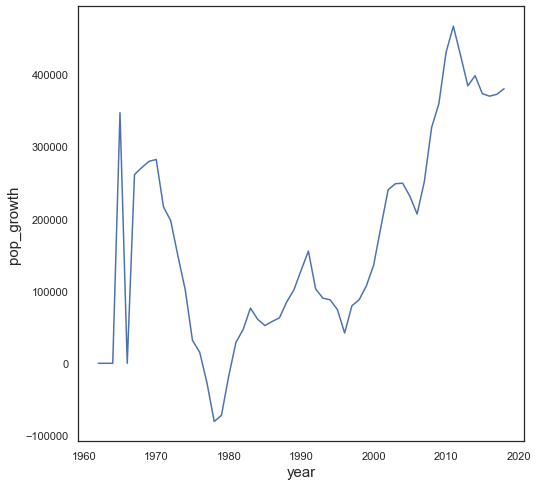

In [564]:
## plot course of pop growth - just to get a picture

sns.lineplot(x = "year", y = "pop_growth", data = df_bev_1) # beginning looks odd, the strady growth starting from the 80ies

In [565]:
## now join the df by year with aggregated temperature data (mean by year)

# aggregate year
df_air_agg = df_air.groupby(["year"]).mean()

# now join
df_air_bev = pd.merge(df_air_agg, df_bev_1, on='year', how='inner')

# rename and select columns
df_air_bev["avg_temp"] = df_air_bev["Zch_Stampfenbachstrasse_Lufttemperatur"]
df_air_bev = df_air_bev[["year", "avg_temp","pop_growth"]].dropna()
df_air_bev = df_air_bev.reset_index(drop=True)

# view
df_air_bev.head(10) #good

,year,avg_temp,pop_growth
0,1992,13.182732,102889.0
1,1993,10.608049,90244.0
2,1994,12.004164,87848.0
3,1995,10.802247,74330.0
4,1996,9.528347,41913.0
5,1997,10.666253,79637.0
6,1998,10.856685,87927.0
7,1999,10.505687,107279.0
8,2000,11.398164,135827.0
9,2001,10.767245,188544.0


In [566]:
## next, add a column with temp_growth

temp_gr = [np.nan] #list of temp differences, first item is NaN

#loop over rows
for i in range(1,df_air_bev.shape[0]): # skip first row for difference of temp
    
    #append difference to list
    tdiff = df_air_bev["avg_temp"][i] - df_air_bev["avg_temp"][i-1]
    temp_gr.append(tdiff)
    
# then, write into dataframe
df_air_bev["temp_growth"] = temp_gr

#drop nan
df_air_bev = df_air_bev.dropna()

# and view
df_air_bev.head(10)

,year,avg_temp,pop_growth,temp_growth
1,1993,10.608049,90244.0,-2.574683
2,1994,12.004164,87848.0,1.396115
3,1995,10.802247,74330.0,-1.201918
4,1996,9.528347,41913.0,-1.273899
5,1997,10.666253,79637.0,1.137906
6,1998,10.856685,87927.0,0.190432
7,1999,10.505687,107279.0,-0.350999
8,2000,11.398164,135827.0,0.892477
9,2001,10.767245,188544.0,-0.630919
10,2002,11.212959,240231.0,0.445714


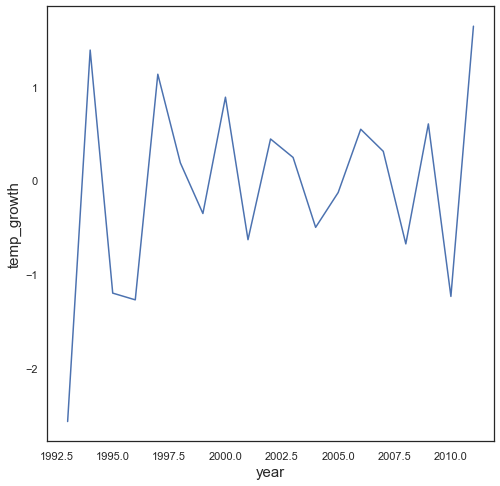

In [567]:
## visualize temp growth - this will later be correlated with population growth
sns.lineplot(x = "year", y = "temp_growth", data = df_air_bev)

## Step 4: Correlations

Two corelation-analyses are performed:

1. Correlations of measurements between two different measurement stations (Stampfenbachstrasse and Schimmelstrasse):
    - For the parameter "Kohlenmonoxid"
    - For the parameter "Stickstoffmonoxid"
2. Correlation between population growth and temperature rise (aggregated per year) in the city of Zurich

### Correlation and visualisation functions

In [568]:
## write own function to get correlation of two vars from df
def mycorr(df, var1, var2):
    
    #calculate correlation
    r,p = pearsonr(df[var1],df[var2])
    
    # print results
    if p < 0.05:
        print("The variables correlate with r = {} (p = {}).".format(round(r,2),round(p,2)))
    else:
        print("The variables do not correlate (p = {})".format(round(p,2)))

In [569]:
## write own function to visualize correlation of two vars from df
def mycorr_plot(df, varx, vary):
    
    #calculate correlation
    r,p = pearsonr(df[varx],df[vary])
    
    
    # plot results
    if p < 0.05: # if significant, plot with regression line
        sns.regplot(x = varx,  
                    y = vary,
                   data = df,
                   line_kws={"color":"black","alpha":1},
                   scatter_kws={"color":"gray","alpha":1,"s":50, "edgecolors":"w"})
        plt.title("Correlation: r = {}".format(round(r,2)))
    else: # if not significant, plot only scatterplot
        sns.scatterplot(x = varx,  
                    y = vary,
                   data = df,
                   color = "gray",
                   s = 50)
        plt.title("No correlation: p = {}".format(round(p,2)))

### Correlation 1: Air quality measures of two measurement stations

In [570]:
# check correlation of "Kohlenmonoxid" measurements between Stampfenbachstrasse and Schimmelstrasse
mycorr(df_air_c2, "Zch_Stampfenbachstrasse_Kohlenmonoxid",  'Zch_Schimmelstrasse_Kohlenmonoxid')

The variables correlate with r = 0.91 (p = 0.0).


In [571]:
# then, check correlation of "Stickstoffmonoxid" measurements between Stampfenbachstrasse and Schimmelstrasse
mycorr(df_air_c2, "Zch_Stampfenbachstrasse_Stickstoffmonoxid",  'Zch_Schimmelstrasse_Stickstoffmonoxid')

The variables correlate with r = 0.92 (p = 0.0).


Now visualize the two correlations:

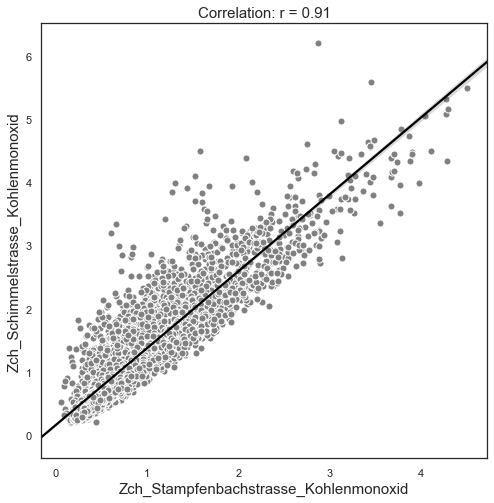

In [572]:
mycorr_plot(df_air_c2, "Zch_Stampfenbachstrasse_Kohlenmonoxid",  'Zch_Schimmelstrasse_Kohlenmonoxid')

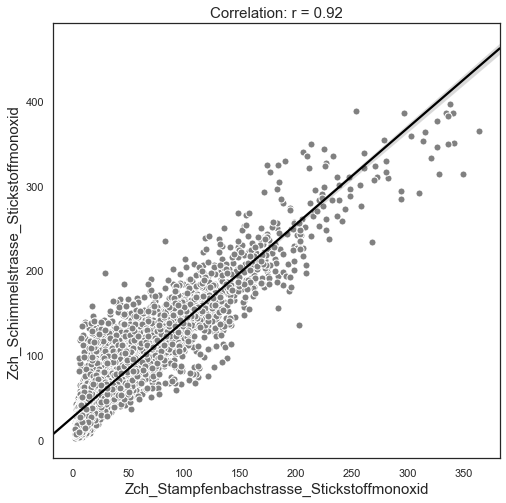

In [573]:
mycorr_plot(df_air_c2, "Zch_Stampfenbachstrasse_Stickstoffmonoxid",  'Zch_Schimmelstrasse_Stickstoffmonoxid')

#### Comment
The meaasurements of the two air quality parameters correlate very well between the two measurement stations. This implies that the overall air quality can be said to be about the same in the whole city of Zurich.  
This justifies that in the next correlation (Correlation 2) only data from one measurement station (Stempfenbachstrasse) will be used - as the values are similar in different measurement stations.

### Correlation 2: Polulation growth vs. temperature rise - both aggregated by year

In [574]:
mycorr(df_air_bev, "temp_growth", "pop_growth")

The variables do not correlate (p = 0.39)


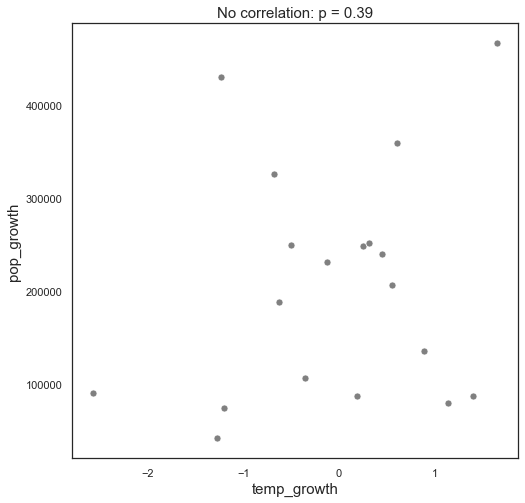

In [575]:
#and visualise:
mycorr_plot(df_air_bev, "temp_growth", "pop_growth")

#### Comment
Temperature rise ("temp_growth") by year and population growth by year do not correlate in the ciry of Zurich. However, it is still possible that the two variables are causally connected and the correlation is "masked" by a time lag (that is, the temperature rises only a few years after the population grows).

## Step 5: Statistical / ML analysis

The goals in this step are:

1) To cunduct a "t-SNE" (t-Distributed Stochastic Neighbor Embedding - a technique for dimensionality reduction) analysis on the airquality data   
2) To visualize the result of the analysis in the first two dimenstions of the t-SNE and see if the summer / winter seasons can be visually distinguished in the plot

In [576]:
df_air.columns[[1,2,3,5,8,9,10]] #arbitrarily selected variables for t-SNE

Index(['Zch_Stampfenbachstrasse_Schwefeldioxid',
       'Zch_Stampfenbachstrasse_Kohlenmonoxid',
       'Zch_Stampfenbachstrasse_Ozon, höchstes Stundenmittel',
       'Zch_Stampfenbachstrasse_Stickstoffdioxid',
       'Zch_Stampfenbachstrasse_Lufttemperatur',
       'Zch_Stampfenbachstrasse_Luftfeuchte relativ',
       'Zch_Stampfenbachstrasse_Luftdruck'],
      dtype='object')

In [577]:
## prepare t-SNE

# first, add month-variable to dataset
# make a year-column using lambda-function - for later labelling 
df_air_tsne = df_air
df_air_tsne['month'] = df_air_tsne['date_col'].map(lambda x: x.month)

# prepare dataset for tsne - and drop na
df_air_tsne = df_air_tsne[df_air.columns[[1,2,3,5,8,9,10,32]]].dropna() #month - column is nr 32

# prepare labels for plot

# months
month_labels = df_air_tsne['month'] #.astype("object")

# and winter / summer - labels
season_labels = []
season_labels_2 = [] #for later selection of rows

for i in month_labels:
    if i > 5 and i < 9:
        season_labels.append("summer") # summer months
        season_labels_2.append("summer") # summer months
        
    elif i > 11 or i < 3:
        season_labels.append("winter") # winter months
        season_labels_2.append("winter") # winter months
        
    else:
        season_labels_2.append("transition") # transition months
        


# then drop label-column from df
df_air_tsne_fit = df_air_tsne.drop(columns = ["month"])

# and view result
df_air_tsne_fit #good for tsne

,Zch_Stampfenbachstrasse_Schwefeldioxid,Zch_Stampfenbachstrasse_Kohlenmonoxid,"Zch_Stampfenbachstrasse_Ozon, höchstes Stundenmittel",Zch_Stampfenbachstrasse_Stickstoffdioxid,Zch_Stampfenbachstrasse_Lufttemperatur,Zch_Stampfenbachstrasse_Luftfeuchte relativ,Zch_Stampfenbachstrasse_Luftdruck
3469,6.35,0.92,95.79,51.93,18.99,70.89,963.06
3470,7.70,1.33,94.66,66.81,18.36,75.34,965.23
3472,4.07,0.66,92.40,33.39,17.53,78.73,960.75
3473,3.43,0.54,59.95,22.53,15.56,82.41,957.95
3474,4.48,0.63,73.39,31.64,17.00,76.31,960.04
...,...,...,...,...,...,...,...
10587,4.15,0.68,4.40,49.56,0.69,91.81,984.37
10588,1.77,0.53,9.40,42.76,0.66,94.18,978.49
10589,2.19,0.31,64.32,27.70,3.96,73.62,975.13
10590,1.30,0.23,68.33,15.83,3.10,78.15,967.05


In [578]:
# check number of data points available fo analysis
df_air_tsne_fit.shape[0]

6899

In [579]:
## perform the t-SNE on the prepared dataset

np.random.seed(123) #set seed for reproducibility of t-sne

tsne = TSNE()
air_embedded = tsne.fit_transform(df_air_tsne_fit) #takes a while ...

In [581]:
## create selection-list that filters only months in summer and winter
choice = []  #indexes of summer or winter months
for i in range(len(season_labels_2)):
    if season_labels_2[i] != "transition":
        choice.append(int(i))

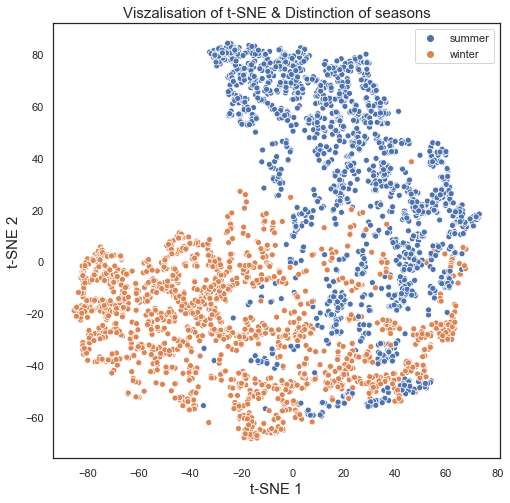

In [582]:
## now visualise the t-SNE and label the summe / winter seasons
ax_tsne = sns.scatterplot(air_embedded[choice,0], air_embedded[choice,1], 
                hue = season_labels, 
                alpha = 1,  legend = "full")

ax_tsne.set(xlabel='t-SNE 1', ylabel='t-SNE 2', title = "Viszalisation of t-SNE & Distinction of seasons")
plt.show()

#### Comment
In the 2D-visualisation of the t-SNE, the two seasons (winter and summer) can be reasonably well distinguished visually. This is unsurprising, as on of the input-variables of the t-SNE was the air temperature which (surprise!) is lower in winter than in summer - the other variables refine the distinction at best.
However, the analysis shows that based on the airquality data a pretty good 2D-distinction of summer and winter days can be made.